# 1. Проверка доступности GPU

In [ ]:
import torch
torch.cuda.is_available()

True

Здесь мы импортируем библиотеку torch и проверяем, доступна ли графическая карта (GPU) для ускорения вычислений. Если GPU доступен, это позволит значительно ускорить обучение модели.

In [ ]:
print("CUDA available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())

CUDA available: True
Number of GPUs: 1


### Как видно Графический процессор доступен (среда colab)

# 2. Импорт необходимых библиотек

In [56]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
!pip install transformers
from transformers import RobertaTokenizerFast,RobertaForSequenceClassification
import torch
from transformers import AdamW
from torch.nn import CrossEntropyLoss
from tqdm import tqdm

### Импортируем необходимые библиотеки для работы с данными, визуализации, обработки текстов, а также для обучения модели. Библиотека transformers используется для работы с предобученными моделями, такими как RoBERTa.

### Здесь мы подключаем google диск.

In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 3. Загрузка данных: загружаем данные из CSV файла содержащего отзывы Amazon.

In [58]:
df = pd.read_csv('/content/drive/MyDrive/Reviews.csv')

# 4. Обработка данных

In [59]:
# Здесь с помощью df.dropna(inplace=True) очищаем DataFrame от строк с отсутствующими значениями,
#затем отображает первые и последние строки, выводим размер DataFrame и возвращаем количество строк.
df.dropna(inplace=True)
display(df.head())
display(df.tail())
print(f"\nPrint out shape:\n{df.shape}")
len(df)



,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...
568453,568454,B001LR2CU2,A3LGQPJCZVL9UC,srfell17,0,0,5,1338422400,Great Honey,"I am very satisfied ,product is as advertised,..."



Print out shape:
(568401, 10)


568401

In [60]:

df = df.sample(frac=0.2, replace=True).reset_index(drop=True)
# Этот код выбирает 20% случайных строк из DataFrame df с возможностью повторного выбора строк и сбрасывает индексы, чтобы они были последовательными и начинались с 0.

In [61]:
len(df)

113680

Score
5    64.038529
4    14.226777
1     9.078994
3     7.426108
2     5.229592
Name: count, dtype: float64


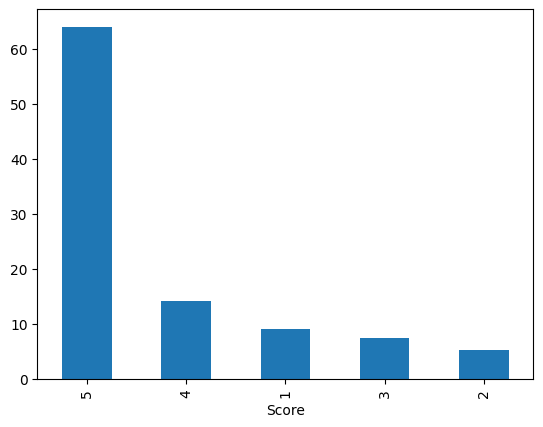

In [62]:
rating_distribution = df['Score'].value_counts() / len(df) * 100
print(rating_distribution)

rating_distribution.plot.bar()
plt.show()

df = pd.DataFrame(df, columns=['Score', 'Text'])
df.rename(columns={'Score': 'Rating', 'Text': 'Review'}, inplace=True)
#GПолучаем новый DataFrame, который содержит только два столбца: 'Rating' и 'Review', вместо исходных 'Score' и 'Text'.

In [63]:
def apply_sentiment(rating): # Функция для индексации рейтинга

    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else:
        return 2

df['Sentiment'] = df['Rating'].apply(apply_sentiment)
df.drop(['Rating'], axis=1, inplace=True)

sentiment = df['Sentiment'].value_counts()
print(sentiment)
display(df.head())

Sentiment
2    88972
0    16266
1     8442
Name: count, dtype: int64


,Review,Sentiment
0,This coffee is a great yummy flavor and a favo...,2
1,"Unlike the other rater, I found the product to...",2
2,"I know these are meant for little kids, but I'...",2
3,I LOVE this delicious coffee. It is full-bodi...,2
4,I had purchased this for my niece who likes ch...,1


# 5. Загрузка токенизатора

In [64]:
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')
max_length = 128

tokenized_reviews = [ #Создается список tokenized_reviews, где каждый отзыв из столбца 'Review' в DataFrame df токенизируется.
    tokenizer.encode(review, add_special_tokens=True, max_length=max_length, padding='max_length', truncation=True) for
    review in df['Review']]

input_ids = torch.tensor(tokenized_reviews) #Здесь список токенов tokenized_reviews преобразуется в тензор PyTorch с помощью torch.tensor(...).
#Это необходимо для последующей передачи данных в модель, так как модели PyTorch ожидают входные данные в виде тензоров.

print(input_ids[:10])

tensor([[    0,   713,  3895,  ...,     1,     1,     1],
        [    0, 38243,     5,  ...,     1,     1,     1],
        [    0,   100,   216,  ...,     1,     1,     1],
        ...,
        [    0,   100,  2162,  ...,     1,     1,     1],
        [    0,   243,   399,  ...,     1,     1,     1],
        [    0,  1629,  5046,  ...,     1,     1,     1]])


# 6. Кодирование и декодирование

In [28]:

decoded_review = tokenizer.decode(input_ids[10]) #происходит декодирование токенов обратно в текст с использованием токенизатора RoBERTa.
# Он берет идентификаторы токенов и сопоставляет их с соответствующими символами или словами, используя словарь, который был загружен вместе с токенизатором
print('Original Review:', df['Review'][10])
print('Decoded Review:', decoded_review)

Original Review: This black tea is not very strong; it's priced reasonably though.  If you're adding a dash of milk into your black tea, this won't do.  If you're drinking it as is, without milk or sugar; it's quite decent.  Faint aroma, doesn't taste as strong or smell as good as Tazo's Awake.  Nevertheless, pretty good value for what you get.
Decoded Review: <s>This black tea is not very strong; it's priced reasonably though.  If you're adding a dash of milk into your black tea, this won't do.  If you're drinking it as is, without milk or sugar; it's quite decent.  Faint aroma, doesn't taste as strong or smell as good as Tazo's Awake.  Nevertheless, pretty good value for what you get.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>


# 7. Сохранение токенизированных данных

In [65]:

torch.save(input_ids, 'tokenized_reviews.pt')
# Эта строка сохраняет тензор input_ids (который содержит токенизированные отзывы) в файл с именем tokenized_reviews.pt.
# Метод torch.save используется для сериализации объектов PyTorch, что позволяет сохранять данные в бинарном формате, чтобы их можно было позже загрузить с помощью torch.load.
with open('decoded_reviews.txt', 'w', encoding='utf-8') as f:
  # В этом цикле происходит итерация по каждому элементу input_ids, который представляет собой токенизированные отзывы.
  #Для каждого review (который является тензором идентификаторов токенов) выполняется:
  #Декодирование токенов в текст с помощью tokenizer.decode(review).
  #Запись декодированного отзыва в файл decoded_reviews.txt с помощью
    for review in input_ids:
        decoded_review = tokenizer.decode(review)
        f.write(decoded_review)
        f.write('\n')
#В результате выполнения этого кода:
# Тензор токенизированных отзывов будет сохранен в бинарном формате в файле tokenized_reviews.pt, что позволит вам легко загружать его позже для дальнейшего анализа или использования в модели.
# Все декодированные отзывы будут записаны в текстовый файл decoded_reviews.txt, где каждый отзыв будет на отдельной строке. Это может быть полезно для просмотра или анализа текстов в удобочитаемом формате.

# 8. Разделение данных на обучающую и тестовую выборки

In [66]:
#Здесь происходит создание обучающего и тестового наборов данных из токенизированных отзывов и соответствующих меток (ярлыков) с использованием функции train_test_split из библиотеки scikit-learn
labels = torch.tensor(df['Sentiment'].values) #Здесь создается тензор labels из значений столбца 'Sentiment' в DataFrame df

train_inputs, test_inputs, train_labels, test_labels = train_test_split(input_ids, labels, random_state=42,
                                                                        test_size=0.3) # Разделение данных на обучающую и тестовую выборки:
                                                                        # Это позволяет модели обучаться на одной части данных (train) и затем оценивать свою производительность
                                                                        # на другой части данных (test), что помогает избежать переобучения и дает более точную оценку эффективности модели.

# 9. Создание загрузчиков данных

In [67]:
batch_size = 64
train_data = TensorDataset(train_inputs, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# 10. Загрузка модели RoBERTa

In [68]:
model = RobertaForSequenceClassification.from_pretrained('roberta-base',num_labels=3) #предобученную модель RoBERTa с именем 'roberta-base', , которая имеет 125 миллионов параметров и была обучена на большом наборе текстовых данных.
# После загрузки мы получаем объект модели model, который готов к обучению или оценке на задаче классификации последовательностей с использованием предобученной модели RoBERTa.
# Эта модель будет иметь 3 выходных класса, что позволяет использовать её для задач, где необходимо различать три категории.

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [69]:
model = model.to('cuda' if torch.cuda.is_available() else 'cpu') # Перемещаем модель на GPU, если он доступен, иначе используем CPU.

In [70]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [71]:
device

'cuda'

# 11. Оптимизация и обучение

In [72]:
# Здесь роисходит настройка оптимизатора и планировщика (scheduler) для обучения модели.
optimizer = Adam(model.parameters(), lr=2e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1, factor=0.5)
print("Current learning rate:", scheduler.get_last_lr())
# В результате зоздается оптимизатор Adam для данной модели с заданной начальной скоростью обучения и настраивается планировщик, который будет автоматически уменьшать скорость обучения, если производительность модели не улучшается.
# Это помогает в управлении обучением и может привести к лучшим результатам.Так же выводится текущее значение скорости обучения, что позволяет отслеживать её изменения в процессе обучения.

Current learning rate: [2e-05]


# 12. Настройки обучения; Функции обратного вызова; Обучение модели



In [73]:
import os
os.environ["WANDB_DISABLED"] = "true"
# Установка значения "true" для переменной окружения WANDB_DISABLED отключает интеграцию WandB.
# Это означает, что любые вызовы функций WandB (например, для логирования метрик или параметров) не будут выполняться, и библиотека не будет пытаться отправлять данные на сервер.

In [74]:
# Здесь осуществляется настройка и запуск тренировки модели с использованием библиотеки transformers от Hugging Face.
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

training_args = TrainingArguments( #  Настройка аргументов тренировки
  #  • output_dir: Директория, куда будут сохранены результаты (модель, логи и т.д.).

  #  • evaluation_strategy: Стратегия оценки модели (в данном случае, оценка будет проводиться по окончании каждой эпохи).

  #  • save_strategy: Стратегия сохранения модели (также сохранение будет происходить по окончании каждой эпохи).

  #  • learning_rate: Скорость обучения.

  #  • per_device_train_batch_size и per_device_eval_batch_size: Размеры батчей для обучения и оценки соответственно.

  #  • num_train_epochs: Количество эпох для обучения.

  #  • weight_decay: Регуляризация L2 для уменьшения переобучения.

  #  • logging_dir: Директория для хранения логов.

  #  • logging_steps: Частота логирования.

  #  • load_best_model_at_end: Если True, будет загружена лучшая модель по метрике.

  #  • metric_for_best_model: Метрика, по которой будет определяться лучшая модель.

  #  • greater_is_better: Указывает, является ли большая величина метрики лучше.
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True
)

def compute_metrics(pred): # Функция для вычисления метрик:
  # Функция принимает предсказания модели и истинные метки, вычисляет предсказанные классы, а затем рассчитывает и возвращает точность, точность, полноту и F1-меру
    logits, labels = pred
    predictions = torch.argmax(torch.tensor(logits), axis=1).numpy()
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted")
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

def data_collator(features): # Функция для коллатора данных
# Эта функция объединяет входные данные и метки в батчи. Она принимает список признаков и возвращает словарь с input_ids и labels.
    input_ids = torch.stack([f[0] for f in features])
    labels = torch.tensor([f[1] for f in features])
    return {"input_ids": input_ids, "labels": labels}
#Создание датасетов: Создаются датасеты для обучения и тестирования, используя TensorDataset, который принимает входные данные и метки.
train_dataset = TensorDataset(train_inputs, train_labels)
test_dataset = TensorDataset(test_inputs, test_labels)

trainer = Trainer( #Создание экземпляра Trainer: Создается экземпляр класса `Trainer`, который принимает модель, аргументы тренировки, датасеты, функцию коллатора и функцию вычисления метрик.
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train() # запускает процесс обучения модели.
trainer.evaluate() # выполняет оценку модели на тестовом наборе данных.

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.232000,0.239500,0.909453,0.908206,0.909453,0.908812
2,0.221700,0.222476,0.919100,0.917920,0.919100,0.918476
3,0.154900,0.236194,0.921563,0.919132,0.921563,0.920240


{'eval_loss': 0.2361944168806076,
 'eval_accuracy': 0.9215634529673938,
 'eval_precision': 0.9191319479674456,
 'eval_recall': 0.9215634529673938,
 'eval_f1': 0.9202395171166905,
 'eval_runtime': 222.1519,
 'eval_samples_per_second': 153.517,
 'eval_steps_per_second': 2.399,
 'epoch': 3.0}

# 13. Сохранение обученной модели

In [75]:
model.save_pretrained('trained_model') # сохраняет вашу обученную модель и её конфигурацию в указанную директорию

# 14. Оценка модели

In [76]:
model.eval()
# Здесь происходит процесс оценки модели на тестовом наборе данных, который включает в себя подготовку данных, выполнение предсказаний и сбор результатов.
# Метод eval() переводит модель в режим оценки. В этом режиме отключаются некоторые функции, такие как дропаут (dropout) и нормализация (batch normalization), которые используются только во время обучения
predictions = [] # Создаются пустые списки для хранения предсказанных меток и истинных меток
true_labels = []

for batch in test_dataloader:
  # В цикле:
  #    • Для каждого батча в test_dataloader:
  #    • Данные перемещаются на устройство (GPU, если доступно, иначе на CPU).
  #    • inputs и labels извлекаются из батча.
    batch = tuple(t.to('cuda' if torch.cuda.is_available() else 'cpu') for t in batch)
    inputs, labels = batch


    with torch.no_grad():
      # • Блок with torch.no_grad() отключает вычисление градиентов, что экономит память и ускоряет вычисления во время оценки, так как градиенты не нужны.
      #  • Модель делает предсказания на входных данных, и выходные логиты извлекаются из результата.
        outputs = model(inputs)
        logits = outputs.logits

# • detach() используется для отделения тензора от графа вычислений.
    logits = logits.detach().cpu().numpy()
#   • Логиты и истинные метки перемещаются на CPU и конвертируются в массивы NumPy для дальнейшей обработки.
    label_ids = labels.to('cpu').numpy()


#   • np.argmax(logits, axis=1) вычисляет предсказанные классы, выбирая индекс максимального логита для каждого примера.
#   • Предсказанные метки добавляются в список predictions, а истинные метки — в список true_labels.
    predictions.extend(np.argmax(logits, axis=1))
    true_labels.extend(label_ids)


# 15. Отчет о классификации

In [77]:
print("\nClassification Report:")
print(classification_report(true_labels, predictions))

#
  #  • Функция classification_report из библиотеки sklearn.metrics принимает два аргумента: истинные метки (true_labels) и предсказанные метки (predictions). Она генерирует текстовый отчет, который включает в себя следующие метрики для каждого класса:

  #    • Precision (точность): Доля верных положительных предсказаний среди всех положительных предсказаний.

  #    • Recall (полнота): Доля верных положительных предсказаний среди всех истинных положительных объектов.

  #    • F1-score: Гармоническое среднее точности и полноты, которое учитывает как ложные положительные, так и ложные отрицательные предсказания.

  #    • Support: Количество истинных экземпляров для каждого класса.



Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.85      0.84      4931
           1       0.58      0.52      0.55      2460
           2       0.97      0.97      0.97     26713

    accuracy                           0.92     34104
   macro avg       0.79      0.78      0.79     34104
weighted avg       0.92      0.92      0.92     34104



### Как видно точность модели больше при негативных и позитивных отзывах При нейтральных точность достаточно низкая

# 18. Матрица путаницы

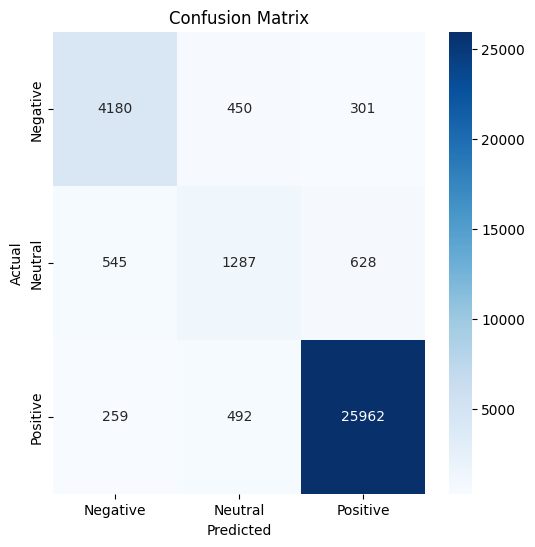

In [78]:
# Здесь мы визуализируем как хорошо модель классифицирует данные, показывая, сколько раз каждый класс был правильно или неправильно предсказан.
confusion_mtx = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# 16. Подсчет точности

In [79]:
# Вычисляем и выводим общую точность модели.
accuracy = np.mean(np.array(true_labels) == np.array(predictions))
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9216


### Как видим общая точность достаточно большая

# 17. Прогнозирование и вывод результатов

In [80]:
sample_messages = [
    "I despise this thing! I distributed it to all of my adversaries! I am enamored with your stuff! I distributed it to all of my pals. However, I am indifferent. That is all I can articulate; I could not compensate my friends sufficiently to relieve me of it. I have not had any communication from them since then. My social life is in disarray. This product is exceptional! It surpassed my expectations and has become a vital component of my everyday routine. This is unequivocally the finest acquisition I have made in a considerable period. The product is exceptionally user-friendly."
    "The product is fine, although I do not consider it remarkable. It functions as intended, although it is inferior to several alternative solutions available.The item arrived punctually and matched the description, although it failed to meet the anticipated expectations. The product is mediocre; it is neither bad nor exceptional. I had high expectations, but it ultimately proved to be a complete financial disappointment. The product is insubstantial and underperforms. I am profoundly dissatisfied with it. It malfunctioned after only a few uses, and the quality is well below my expectations."
]

In [93]:
sample_messages = ['So-so product, it will do'] # Здесь нейтральная тема

In [94]:
sample_tokenized = [
    tokenizer.encode(message, add_special_tokens=True, max_length=max_length, padding='max_length', truncation=True)
    for message in sample_messages
]


sample_input_ids = torch.tensor(sample_tokenized)


sample_data = TensorDataset(sample_input_ids)
sample_dataloader = DataLoader(sample_data, batch_size=batch_size)

In [95]:
model.eval()

# Инициализируется пустой список для хранения предсказанных меток для использования обрбатываемых образцов в цикле.
sample_predictions = []


for inputs in sample_dataloader:

    inputs = inputs[0].to('cuda' if torch.cuda.is_available() else 'cpu')


    with torch.no_grad():

        outputs = model(inputs)
        logits = outputs.logits


    probs = torch.softmax(logits, dim=1)


    confidences, predicted_labels = torch.max(probs, dim=1)


    confidences = confidences.detach().cpu().numpy()
    predicted_labels = predicted_labels.detach().cpu().numpy()

    # Сюда перемещаются предсказанные метки
    sample_predictions.extend(predicted_labels)

In [96]:
# Выводим результат предсказания (оценки тестовой фразы)
sentiment_mapping = {0: "Negative", 1: "Neutral", 2: "Positive"}
for message, prediction, confidence in zip(sample_messages, sample_predictions, confidences):
    print(f"Message: {message}\nPrediction: {sentiment_mapping[prediction]}, Confidence: {confidence:.4f}\n")

Message: So-so product, it will do
Prediction: Neutral, Confidence: 0.6670



### Как видим нейтральная фраза предсказана была правилно, но с оценкой точности чуть более 0.6 Для положительных и негативных отзывов она была больше 0.9